In [1]:
import string
import re
import os
import tempfile
import logging
import csv
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from datetime import datetime
from gensim import corpora
from gensim import models
from gensim.corpora import Dictionary
from collections import namedtuple
import gensim.parsing.preprocessing as processing
from os import listdir
import CustomApi as api
#Start Global Variables and Types

#document dir
docs = "../data/documents/"

#Number of topics the model should index
numberOfTopics = 225

#Number of passes the model should make
passes = 75

#Keyphrase tracker
keyphraseTracker = api.KeyWordTracker()

#End Global Variables and Types

C:\Users\hp-pc\Anaconda3\envs\p2\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
files = listdir(docs+"lt2006/")
entries = []
for file in files:
    with open(docs+"lt2006/"+file,"rb") as csvfile:
        spamreader = csv.reader(csvfile)
        for row in spamreader:
            if "Authors" not in row[0] and row[15] !='[No abstract available]':
                entries.append(row)
        

In [3]:
files1 = listdir(docs+"gt2016/")

for file in files1:
    with open(docs+"gt2016/"+file,"rb") as csvfile:
        spamreader = csv.reader(csvfile)
        for row in spamreader:
            if "Authors" not in row[0] and row[15] !='[No abstract available]':
                entries.append(row)
        

In [4]:
# Create a set of frequent words
stopFile = open("../data/stopwords.txt","r")
stopWords = stopFile.read().splitlines() #This is the copyright symbol, this shows up in every abstract and should not be apart of the corpus
stopWords.extend([u"\u2019",u"\u03bc","bee","bees","honey","honeybee","honeybees",u"\xa9",u"\xc2"])
# for asc in range(97,123):
#     stopWords.extend([chr(asc)])
with open("../data/extraStopWords.txt","r") as extraStopFile:
    stopWords.extend(extraStopFile.read().split("\n"))
# Lowercase each document, split it by white space and filter out stopWords
stopList = set(stopWords)
processing.STOPWORDS = stopList
ps = PorterStemmer()
def removeStops(text):
    stopsRemoved = processing.remove_stopwords(text.lower().translate(None, string.punctuation))
    words = stopsRemoved.split(" ")
    stemmedWords = []
    for w in words:
        if len(ps.stem(w)) > 2:
            stemmedWords.append(ps.stem(w))
    return ' '.join(stemmedWords)
# Each abstract has a 'title':String, 'date':datetime.datetime, 'text':String, and 'keywords':String
abstracts = [api.MyAbstract._make([art[1],datetime.strptime(art[2], '%Y'),removeStops(art[15]), art[16]]) for art in entries]
abstracts.sort(key=lambda q: q.date.year)
entries = None
# Count word frequencies
selections = []

access = lambda x: x.date.year
lastIndex = 0
for i in range(1957,2019):
    index = api.binarySearch(abstracts,i,access)
    if  index != -1:
        selections.append(abstracts[lastIndex:index+1])
        lastIndex = index+1
        

In [12]:
size = 0
start = 0
import os
keyphraseTracker = api.KeyWordTracker()
for i in range(0,len(selections)):
    
    size += len(selections[i])
    if size >=50:
        selection = api.flaten(selections[start:i+1])
        for abstr in selection:
            phrases = [k.strip() for k in  abstr.keywords.split(";")]
            for phr in phrases:
                words = [ps.stem(w) if all(ord(c) < 128 for c in w) else None for w in phr.split(" ")]
                string = ""
                for w in words:
                    if w != None:
                        string = string +" "+ w
                string = string.strip()
                if len(string) > 2:
                    #print(string)
                    keyphraseTracker.track(string,abstr.date.year)
        selection = None
        size = 0
        start = i+1
for y in keyphraseTracker.topN():
    print str(y.getPhrase())+", "+str(y.sum())
        #continue to next section

api mellifera, 3389
honey bee, 1424
honeybe, 1356
pollin, 614
varroa destructor, 505
honey, 258
forag, 228
bee, 227
insect, 211
pollen, 208
propoli, 186
hymenoptera, 183
social insect, 182
api cerana, 162
nosema cerana, 160
varroa jacobsoni, 148
pesticid, 141
royal jelli, 139
api, 134
american foulbrood, 119
apida, 118
beekeep, 109
stingless bee, 107
paenibacillu larva, 106
african honey bee, 104
learn, 103
pheromon, 99
nectar, 98
microsatellit, 97
neonicotinoid, 96
nosema api, 93
gene express, 93
juvenil hormon, 92
reproduct, 90
drone, 90
divis of labor, 89
nutrit, 85
mushroom bodi, 84
waggl danc, 84
olfact, 81
bee venom, 81
commun, 79
api mellifera carnica, 77
varroa, 77
imidacloprid, 77
resist, 76
aethina tumida, 76
swarm, 75
bombu, 74
ecosystem servic, 74


In [13]:
y = keyphraseTracker.words[ps.stem("pollen")]
print y.years

{1983: 1, 1984: 1, 1986: 1, 1988: 1, 1989: 1, 1991: 1, 1992: 3, 1993: 4, 1994: 2, 1995: 1, 1996: 3, 1997: 3, 1998: 6, 1999: 5, 2000: 8, 2001: 4, 2002: 2, 2003: 7, 2004: 7, 2005: 9, 2006: 11, 2007: 8, 2008: 9, 2009: 9, 2010: 16, 2011: 11, 2012: 10, 2013: 6, 2014: 17, 2015: 13, 2016: 10, 2017: 11, 2018: 7}


In [20]:
for y in keyphraseTracker.topN(500):
    print str(y.getPhrase())+str(y.peakYear())+", "+str(y.sum()), + y.years

 api mellifera(2017, 208), 3389

TypeError: bad operand type for unary +: 'str'

In [25]:
for y in keyphraseTracker.topN(500):
    print y.years

{1970: 1, 1971: 2, 1972: 3, 1973: 1, 1974: 1, 1975: 2, 1978: 2, 1979: 3, 1980: 3, 1981: 3, 1982: 9, 1983: 2, 1984: 5, 1985: 17, 1986: 6, 1987: 14, 1988: 15, 1989: 12, 1990: 8, 1991: 36, 1992: 27, 1993: 39, 1994: 63, 1995: 48, 1996: 69, 1997: 82, 1998: 87, 1999: 79, 2000: 94, 2001: 96, 2002: 79, 2003: 135, 2004: 128, 2005: 127, 2006: 96, 2007: 139, 2008: 168, 2009: 141, 2010: 181, 2011: 160, 2012: 191, 2013: 180, 2014: 186, 2015: 172, 2016: 175, 2017: 208, 2018: 94}
{1972: 2, 1973: 1, 1975: 1, 1976: 1, 1977: 2, 1978: 1, 1979: 2, 1980: 4, 1981: 4, 1982: 3, 1983: 2, 1984: 2, 1985: 3, 1986: 6, 1987: 4, 1988: 6, 1989: 5, 1990: 4, 1991: 21, 1992: 14, 1993: 19, 1994: 36, 1995: 16, 1996: 11, 1997: 36, 1998: 43, 1999: 25, 2000: 40, 2001: 50, 2002: 29, 2003: 48, 2004: 59, 2005: 48, 2006: 40, 2007: 48, 2008: 53, 2009: 55, 2010: 82, 2011: 64, 2012: 84, 2013: 84, 2014: 69, 2015: 70, 2016: 79, 2017: 92, 2018: 56}
{1972: 1, 1976: 1, 1977: 1, 1979: 1, 1980: 3, 1981: 2, 1982: 7, 1983: 2, 1984: 3, 1985:

In [133]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from matplotlib.backends.backend_pdf import PdfPages
path = docs+'GraphFiles/'
try:
    os.makedirs(path)
    print "made dirs"
except:
    #Already exists
    pass
out_pdf =docs+'GraphFiles/'+ 'keyword_graph.pdf'
pdf = matplotlib.backends.backend_pdf.PdfPages(out_pdf)

figs = plt.figure()

#pp = PdfPages('multigraph.pdf')

<Figure size 432x288 with 0 Axes>

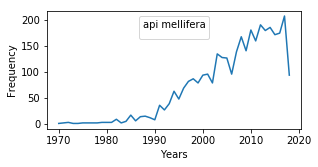

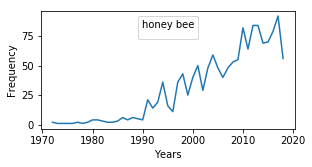

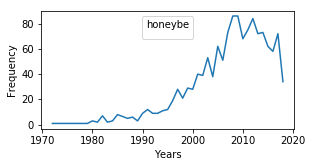

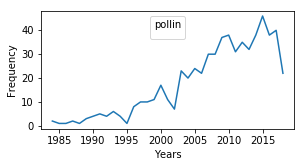

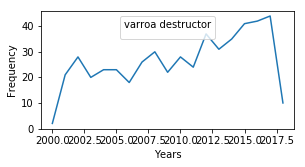

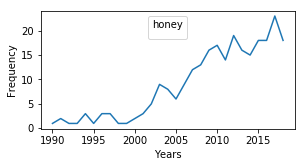

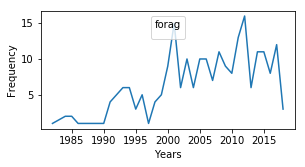

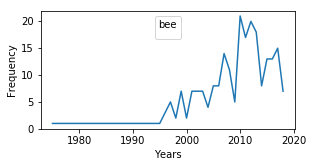

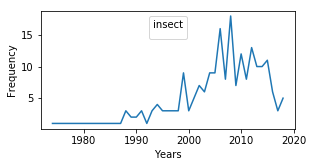

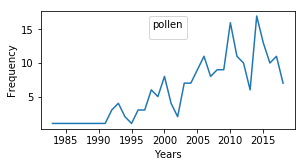

In [134]:
plot_num = 321
for yr in keyphraseTracker.topN(10):
    
    fig = plt.figure(figsize=(10, 10)) # inches
    x=sorted(yr.years)
    
    y=[]
    for i in x:
        y.append(yr.years[i])
    #x=(sd).keys()
    #y=sd.values()
    plt.subplot(plot_num)
    plt.plot(x,y)
    plt.xlabel("Years")
    plt.ylabel("Frequency")
    plt.legend(title=str(yr.getPhrase()),loc='upper center')
    if plot_num%2==0:
        plot_num -= 1
    else :
        
        plot_num += 1
    pdf.savefig(fig)
pdf.close()
    
    